# Introductory figures

Figure 1 inspired by Figure 1 in Venturelli et al., 2020: https://github.com/mrsiegfried/Venturelli2020-GRL

Venturelli, R. A., Siegfried, M. R., Roush, K. A., Li, W., Burnett, J., & Zook, R., et al. (2020). Mid-Holocene grounding line retreat and readvance at Whillans Ice Stream, West Antarctica. Geophysical Research Letters, 47, e2020GL088476. https://doi.org/10.1029/2020GL088476 

In [1]:
# general
import numpy as np
import xarray as xr
import rioxarray
from pathlib import Path
import pandas as pd
from scipy.interpolate import griddata
import cmocean
import geopandas as gpd
import verde as vd

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as colors

# custom
from utilities import get_topo_cm

## Set paths to data

Note for the shapefiles to work you need all the other files in the folder, e.g., .dbf, .prj, .evf, etc.

In [2]:
# local gravity
grav_path = Path('processed_data/grav_combined.csv')

# local BedMachine
bm_trim_path = Path('processed_data/xr_2000.nc')

# whole BedMachine: https://nsidc.org/data/nsidc-0756/versions/3
bm_path = Path('raw_data/bedmachine/BedMachineAntarctica-v3.nc')

# MEASURES phase velocity: https://nsidc.org/data/nsidc-0754/versions/1
vel_path = Path('raw_data/phase_vel/antarctic_ice_vel_phase_map_v01.nc')

# MOA: https://nsidc.org/data/nsidc-0730/versions/1
moa_base = Path('raw_data/nsidc0730_MEASURES_MOA2014_v01')
moa_tif = moa_base/'geotiff/moa750_2014_hp1_v01.tif'
moa_coast_path = moa_base/'coastlines/moa2014_coastline_v01.shp'
moa_gl_path = moa_base/'coastlines/moa2014_grounding_line_v01.shp'

# grounding zone: https://nsidc.org/data/nsidc-0778/versions/1
gzone_path = Path('raw_data/grounding_zone/Antarctic_GZ_2018_v01.0.shp')

# figure saving
figpath = Path('figures/')
filetype = 'pdf'
dpi = 300

## Load data trimmed and full BedMachine

In [3]:
ds = xr.open_dataset(bm_trim_path)
xx, yy = np.meshgrid(ds.x.values, ds.y.values)

grid = xr.open_dataset(bm_path)

x_trim = (grid.x >= np.min(xx)) & (grid.x <= np.max(xx))
y_trim = (grid.y >= np.min(yy)) & (grid.y <= np.max(yy))

grid = grid.sel(x=x_trim, y=y_trim)

gridxkm = grid.x/1000
gridykm = grid.y/1000

## Load MOA tif

In [4]:
img = rioxarray.open_rasterio(moa_tif)

msk1 = (img.x.values > np.min(ds.x.values)-5e3) & (img.x.values < np.max(ds.x.values)+5e3)
msk2 = (img.y.values > np.min(ds.y.values)-5e3) & (img.y.values < np.max(ds.y.values)+5e3)

img = img.sel(x=msk1, y=msk2, band=1)

img_xx, img_yy = np.meshgrid(img.x.values, img.y.values)
grid_xx, grid_yy = np.meshgrid(grid.x.values, grid.y.values)

img_grid = griddata((img_xx.flatten(), img_yy.flatten()), img.values.flatten(), (grid_xx.flatten(), grid_yy.flatten()))
img_grid = img_grid.reshape(grid_xx.shape)

In [5]:
moa_cmap = 'gray'
moa_vmin = 6e3
moa_vmax = 20e3

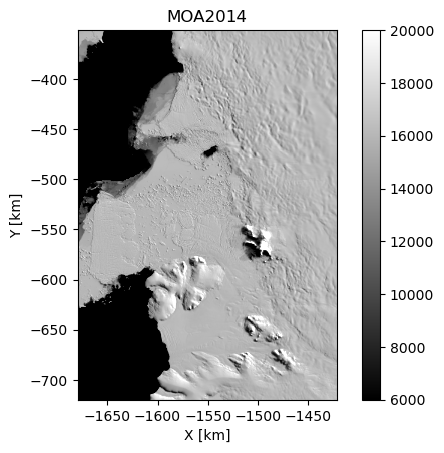

In [6]:
plt.pcolormesh(grid.x/1000, grid.y/1000, img_grid, cmap=moa_cmap, vmin=moa_vmin, vmax=moa_vmax)
plt.axis('scaled')
plt.title('MOA2014')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar()
plt.show()

## Load MEASURES phase velocity

In [7]:
vel = xr.open_dataset(vel_path)

msk1 = (vel.x.values >= np.min(ds.x.values)) & (vel.x.values <= np.max(ds.x.values))
msk2 = (vel.y.values >= np.min(ds.y.values)) & (vel.y.values <= np.max(ds.y.values))

vel = vel.sel(x=msk1, y=msk2)

vel['MAG'] = (('y','x'), np.sqrt(vel['VX'].values**2+vel['VY'].values**2))
vel['ANGLE'] = (('y','x'), np.arctan2(vel['VY'].values, vel['VX'].values))

In [8]:
vel_coarse = vel.coarsen(x=16, y=16, boundary='trim').median()

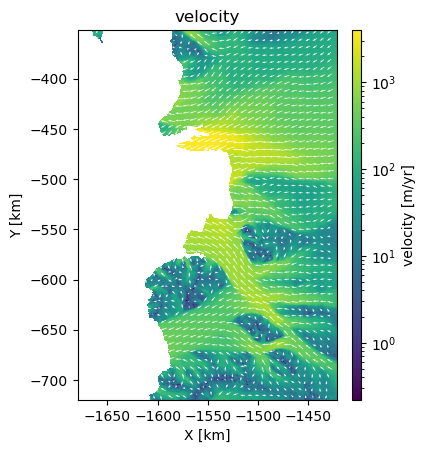

In [9]:
def transform(u, v):
    """
    Log transform quiver arrow lengths
    """
    arrow_lengths = np.sqrt(u*u + v*v)
    len_adjust_factor = np.log10(arrow_lengths + 1) / arrow_lengths
    return u*len_adjust_factor, v*len_adjust_factor

u_log, v_log = transform(vel_coarse.VX, vel_coarse.VY)

vel_vmin = vel.MAG.min().values
vel_vmax = vel.MAG.max().values

im = plt.pcolormesh(vel.x/1000, vel.y/1000, vel.MAG, norm=colors.LogNorm(vmin=vel_vmin, vmax=vel_vmax))
plt.quiver(vel_coarse.x/1000, vel_coarse.y/1000, u_log, v_log, color='white', angles='xy', 
           headwidth=3, pivot='tip', scale=1e2)
plt.axis('scaled')
plt.title('velocity')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(im, pad=0.03, aspect=40, label='velocity [m/yr]')
plt.show()

## Load local gravity dataset

In [10]:
grav_dens = pd.read_csv(grav_path)
grav_dens = grav_dens.iloc[::10,:]
grav_dens.head()

,x,y,lat,lon,height,faa,oib
0,-1660466.10,-635658.23,-73.741659,-110.947803,613.26,-6.88,1.0
10,-1659900.82,-636157.15,-73.744813,-110.969335,585.54,-6.54,1.0
20,-1659336.90,-636653.08,-73.747963,-110.990770,555.74,-6.30,1.0
30,-1658774.09,-637146.01,-73.751111,-111.012110,528.52,-6.23,1.0
40,-1658212.44,-637636.19,-73.754257,-111.033362,500.26,-6.37,1.0


## Load MOA coast and grounding line and grounding zone

In [11]:
# moa coast and grounding line
moa_coast=gpd.read_file(moa_coast_path)
moa_gl=gpd.read_file(moa_gl_path)

# grounding zone
gzone = gpd.read_file(gzone_path)

## Parameters for plot

In [12]:
# velocity cmap
vel_cmap = cmocean.cm.haline

# legend frame trasparency
framealpha = 0.8

# legend frame color
framecolor = 'white'

# gravity dataset colormap
grav_cmap = plt.get_cmap('PuOr')
grav_cmap = cmocean.tools.crop_by_percent(grav_cmap, 40, which='both', N=None)

# Make intro figure

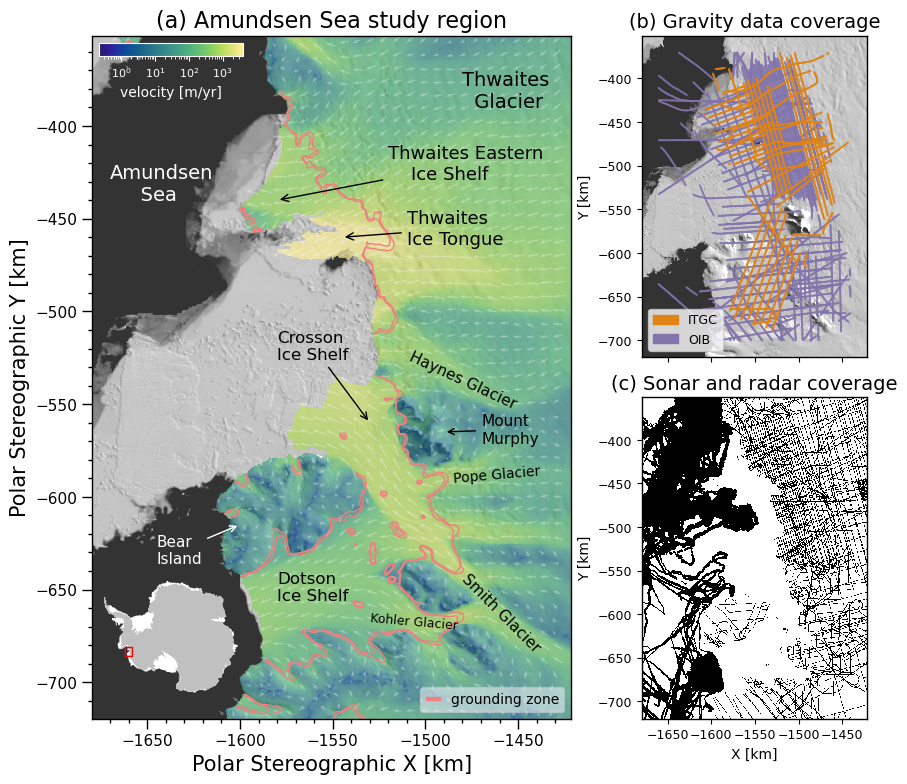

In [13]:
# start figure
fig = plt.figure(figsize=(10,9))

# set up 2x2 gridspec with thinner right column
gs = GridSpec(2, 2, width_ratios=[1, 0.47], hspace=0.09)

### plot MOA and velocity magnitude and quiver
ax = fig.add_subplot(gs[:,0])
ax.pcolormesh(gridxkm, gridykm, img_grid, cmap=moa_cmap, vmin=moa_vmin, vmax=moa_vmax, alpha=0.8, rasterized=True)
im = ax.pcolormesh(vel.x/1000, vel.y/1000, vel.MAG, norm=colors.LogNorm(vmin=vel_vmin, vmax=vel_vmax), alpha=0.7, cmap=vel_cmap, rasterized=True)
ax.quiver(vel_coarse.x/1000, vel_coarse.y/1000, u_log, v_log, color='w', angles='xy', 
           headwidth=3, pivot='tip', scale=1e2, alpha=0.3)

ax.axis('scaled')
ax.set_xlabel('Polar Stereographic X [km]', fontsize=15)
ax.set_ylabel('Polar Stereographic Y [km]', fontsize=15)
ax.set_title('(a) Amundsen Sea study region', fontsize=16)
cax = inset_axes(ax, width="30%", height="2%", loc='upper left')
cb = plt.colorbar(im, pad=0.03, cax=cax, orientation='horizontal')
fg_color = 'w'
cb.set_label('velocity [m/yr]', color=fg_color, size=10)
cb.ax.xaxis.set_ticks([1, 10, 100, 1000])

# set colorbar tick color
cb.ax.xaxis.set_tick_params(color=fg_color, labelsize=8, which='both')
#cb.ax.minorticks_off()

# set colorbar edgecolor 
cb.outline.set_edgecolor(fg_color)
cb.solids.set(alpha=1)

# set colorbar ticklabel color
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color=fg_color)

# reproject grounding zone from m to km and plot
gzonekm = gzone.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')
gzonekm.plot(facecolor='none', edgecolor='lightcoral', ax=ax, linewidth=1)

# make grounding zone legend with patch
gzone_patch = mpatches.Patch(color='lightcoral', label=r'grounding zone')
ax.legend(handles=[gzone_patch], fontsize=10, frameon=True, loc='lower right', handlelength=1, 
          handleheight=0.01, facecolor=framecolor, framealpha=0.5)

# coastline doesn't correspond with velocity data
# moa_coastkm = moa_coast.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')
# moa_coastkm.plot(facecolor='none', edgecolor='blue', ax=ax, linewidth=1)

# set up white and black arrows
white_arrow = dict(arrowstyle="->", connectionstyle="arc3", color='w')
black_arrow = dict(arrowstyle="->", connectionstyle="arc3", color='k')

# add text and annotations
ax.text(-1480, -370, 'Thwaites\n  Glacier', color='k', fontsize=14, ha='left', va='top')
ax.text(-1670, -420, 'Amundsen\n     Sea', color='w', fontsize=14, ha='left', va='top')
ax.text(-1580, -640, 'Dotson\nIce Shelf', color='k', fontsize=12, ha='left', va='top')
ax.text(-1482, -640, 'Smith Glacier', color='k', fontsize=11, ha='left', va='top', rotation=-45)
ax.text(-1530, -662, 'Kohler Glacier', color='k', fontsize=9, ha='left', va='top', rotation=-5)
ax.text(-1510, -520, 'Haynes Glacier', color='k', fontsize=11, ha='left', va='top', rotation=-25)
ax.text(-1485, -582, 'Pope Glacier', color='k', fontsize=10, ha='left', va='top', rotation=5)
ax.annotate('Crosson\nIce Shelf', xy=(-1530, -560), xytext=(-1580, -510), arrowprops=black_arrow, color='k', fontsize=12, ha='left', va='top')
ax.annotate('Thwaites Eastern\n    Ice Shelf', xy=(-1580, -440), xytext=(-1520, -410), arrowprops=black_arrow, color='k', fontsize=13, ha='left', va='top')
ax.annotate('Thwaites \nIce Tongue', xy=(-1545, -460), xytext=(-1510, -445), arrowprops=black_arrow, color='k', fontsize=13, ha='left', va='top')
ax.annotate('Bear\nIsland', xy=(-1600, -615), xytext=(-1645, -620), arrowprops=white_arrow, color='w', fontsize=11, ha='left', va='top')
ax.annotate('Mount\nMurphy', xy=(-1490, -565), xytext=(-1470, -555), arrowprops=black_arrow, color='k', fontsize=11, ha='left', va='top')

# modify axis ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=3)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)

# make axis frame thinner
ax.spines[:].set_linewidth(1)

### Put picture of Antarctica and bounding box in inset axis
inset_ax = inset_axes(ax, width="30%", height="15%", loc='lower left', bbox_to_anchor=(-0.03, .02, 1.2, 1.2),
                   bbox_transform=ax.transAxes)
moa_coast.plot(facecolor='white', edgecolor='none', ax=inset_ax)
inset_ax.patch.set_alpha(0.0)
inset_ax.axis('scaled')
inset_ax.axis('off')

moa_gl.plot(facecolor='silver', edgecolor='none', ax=inset_ax)

xmin = np.min(ds.x.values)
xmax = np.max(ds.x.values)
ymin = np.min(ds.y.values)
ymax = np.max(ds.y.values)

# put rectangle patch for study region on Antarctica
rect = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin)
collection = PatchCollection([rect], edgecolor='r', facecolor='none')
inset_ax.add_collection(collection)

### Plot MOA and OIB and ITGC dataset

# make boundary norm
bounds = [-0.5, 0.5, 1.5]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

ax = fig.add_subplot(gs[0,1])
ax.pcolormesh(gridxkm, gridykm, img_grid, cmap=moa_cmap, vmin=moa_vmin, vmax=moa_vmax, alpha=0.8, rasterized=True)
im = ax.scatter(grav_dens.x/1000, grav_dens.y/1000, c=grav_dens.oib, s=0.1, norm=norm, cmap=grav_cmap, alpha=1, rasterized=True)
ax.axis('scaled')
ax.set_xlim(gridxkm.min(), gridxkm.max())
ax.set_ylim(gridykm.min(), gridykm.max())
ax.xaxis.set_tick_params(labelsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.set_ylabel('Y [km]')
ax.set_xticklabels([])
ax.set_title('(b) Gravity data coverage', fontsize=14)
ax.spines[:].set_linewidth(1)

# make patches for gravity dataset legend
grav_patch1 = mpatches.Patch(color=grav_cmap(0), label='ITGC')
grav_patch2 = mpatches.Patch(color=grav_cmap(1.0), label=r'OIB')
ax.legend(handles=[grav_patch1, grav_patch2], fontsize=9, frameon=True, loc='lower left')

### Plot BedMachine hard data
ax = fig.add_subplot(gs[1,1])
ax.pcolormesh(gridxkm, gridykm, np.where(grid.dataid.data>0, 1, np.nan), cmap='binary_r', rasterized=True)
ax.axis('scaled')
ax.set_title('(c) Sonar and radar coverage', fontsize=14)
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.xaxis.set_tick_params(labelsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.spines[:].set_linewidth(1)

if filetype=='pdf':
    # bbox_inches='tight' doesn't work with saving pdf right now
    plt.savefig(figpath/f'intro_fig.{filetype}', dpi=72, format=filetype, bbox_inches='tight')
else:
    plt.savefig(figpath/f'intro_fig.{filetype}', dpi=dpi, format=filetype, bbox_inches='tight')

plt.show()

# BedMachine figure

In [14]:
# trimmed BedMachine x and y in km
xkm = ds.x/1000
ykm = ds.y/1000

## interpolate masks to finer grid for contour

In [15]:
# make finer grid 1000 x 1000
x_dens = np.linspace(np.min(ds.x.values), np.max(ds.x.values), 1000)
y_dens = np.linspace(np.min(ds.y.values), np.max(ds.y.values), 1000)

xx_dens, yy_dens = np.meshgrid(x_dens, y_dens)
xx_denskm = xx_dens/1000
yy_denskm = yy_dens/1000

xx, yy = np.meshgrid(ds.x.values, ds.y.values)

# interpolate inversion domain
kn = vd.KNeighbors(1)
kn.fit((xx.flatten(), yy.flatten()), ds.inv_msk.values.flatten())
preds = kn.predict((xx_dens, yy_dens))
inv_dens = preds.reshape(xx_dens.shape) > 0.5

# interpolate ice shelf mask
kn = vd.KNeighbors(1)
kn.fit((xx.flatten(), yy.flatten()), ds.mask.values.flatten())
preds = kn.predict((xx_dens, yy_dens))
ice_shelf_dens = preds.reshape(xx_dens.shape) == 3

## plot parameters

In [16]:
# inversion domain color
inv_c = 'k'

# ice shelf color
shelf_c = 'dimgray'

# custom bathymetry colormap
topo_cmap = get_topo_cm()
topo_crop = cmocean.tools.crop(topo_cmap, np.min(ds.bed_no_muto), np.max(ds.bed_no_muto), 0)
vmin_topo = np.min(ds.bed_no_muto); vmax_topo = np.max(ds.bed_no_muto)

# ice thickness colormap modifed for gray NaN
cmap_thick = plt.get_cmap('cmo.dense')
# cmap_thick = cmocean.cm.ice
# cmap_thick = cmocean.tools.crop_by_percent(cmap_thick, 20, which='min', N=None)
cmap_thick.set_bad('gray')

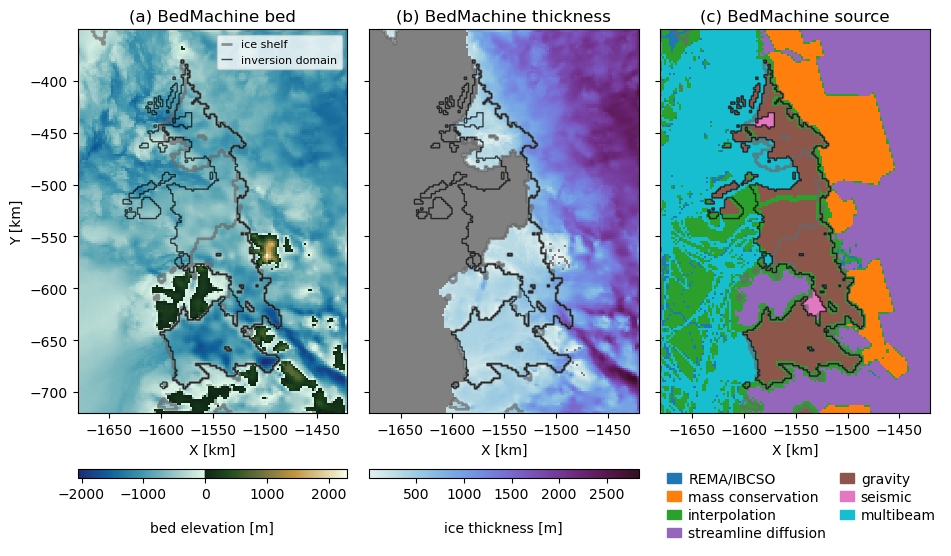

In [17]:
fig = plt.figure(figsize=(11,6))

# set up gridspec with 2 rows and 3 columns (bottom row for colorbars)
gs = GridSpec(2, 3, wspace=0.08, height_ratios=[1, 0.02])

# add axes
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

# plot bed
im1 = ax1.pcolormesh(xkm, ykm, ds.bed, cmap=topo_crop, vmin=vmin_topo, vmax=vmax_topo, rasterized=True)
ax1.set_title('(a) BedMachine bed')

# plot thickness
im2 = ax2.pcolormesh(xkm, ykm, np.where(ds.thickness>0, ds.thickness, np.nan), cmap=cmap_thick, rasterized=True)
ax2.set_title('(b) BedMachine thickness')

# plot source
ax3.pcolormesh(xkm, ykm, ds.source, cmap='tab10', rasterized=True)
ax3.set_title('(c) BedMachine source')

# add inversion domain and ice shelf outlines to alld
for ax in [ax1, ax2, ax3]:
    cs1 = ax.contour(xx_denskm, yy_denskm, ice_shelf_dens, levels=[0], colors=shelf_c, antialiased=True, linewidths=2, alpha=0.7)
    cs2 = ax.contour(xx_denskm, yy_denskm, inv_dens, levels=[0], colors=inv_c, antialiased=True, linewidths=1, alpha=0.7)
    ax.set_xlabel('X [km]')
    ax.axis('scaled')

ax1.set_ylabel('Y [km]')
ax2.set_yticklabels([])
ax3.set_yticklabels([])

# make legend for outlines
handles1, _ = cs1.legend_elements()
handles2, _ = cs2.legend_elements()
ax1.legend(handles1+handles2, ['ice shelf', 'inversion domain'], frameon=True, fontsize=8, handlelength=1, framealpha=framealpha, facecolor=framecolor)

# bed colorbar
cax = fig.add_subplot(gs[1,0])
cb = plt.colorbar(im1, cax=cax, orientation='horizontal')
cb.set_label('bed elevation [m]', labelpad=14)

# ice thickness colorbar
cax = fig.add_subplot(gs[1,1])
cb = plt.colorbar(im2, cax=cax, orientation='horizontal')
cb.set_label('ice thickness [m]', labelpad=14)

# dictionary of BedMachine source
source_dict = {
    1 : 'REMA/IBCSO',
    2 : 'mass conservation',
    3 : 'interpolation',
    4 : 'hydrostatic',
    5 : 'streamline diffusion',
    6 : 'gravity',
    7 : 'seismic',
    10 : 'multibeam'
}
# make patches for legend with correct colors
tab10 = plt.get_cmap('tab10')
patches = []
for i, val in enumerate(np.unique(ds.source)):
    patch = mpatches.Patch(color=tab10.colors[int(val)-1], label=source_dict[int(val)])
    patches.append(patch)

# add source legend
ax3.legend(handles=patches, frameon=False, fontsize=10, handlelength=1, loc='upper left', bbox_to_anchor=(-0.02, -0.12), ncols=2, columnspacing=1, handletextpad=0.5, labelspacing=0.3)

plt.savefig(figpath/f'bed_thick_source.{filetype}', dpi=300, format=filetype, bbox_inches='tight')

plt.show()

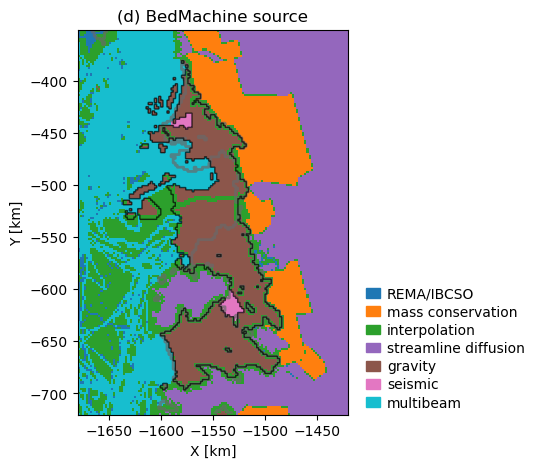

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

# plot source
ax.pcolormesh(xkm, ykm, ds.source, cmap='tab10', rasterized=True)
ax.set_title('(d) BedMachine source')

# add inversion domain and ice shelf outlines to alld
cs1 = ax.contour(xx_denskm, yy_denskm, ice_shelf_dens, levels=[0], colors=shelf_c, antialiased=True, linewidths=2, alpha=0.7)
cs2 = ax.contour(xx_denskm, yy_denskm, inv_dens, levels=[0], colors=inv_c, antialiased=True, linewidths=1, alpha=0.7)
ax.set_xlabel('X [km]')
ax.axis('scaled')

ax.set_ylabel('Y [km]')
ax.set_xlabel('X [km]')

# make legend for outlines
handles1, _ = cs1.legend_elements()
handles2, _ = cs2.legend_elements()
ax.legend(handles1+handles2, ['ice shelf', 'inversion domain'], frameon=True, fontsize=8, handlelength=1, framealpha=framealpha, facecolor=framecolor)

# dictionary of BedMachine source
source_dict = {
    1 : 'REMA/IBCSO',
    2 : 'mass conservation',
    3 : 'interpolation',
    4 : 'hydrostatic',
    5 : 'streamline diffusion',
    6 : 'gravity',
    7 : 'seismic',
    10 : 'multibeam'
}
# make patches for legend with correct colors
tab10 = plt.get_cmap('tab10')
patches = []
for i, val in enumerate(np.unique(ds.source)):
    patch = mpatches.Patch(color=tab10.colors[int(val)-1], label=source_dict[int(val)])
    patches.append(patch)

# add source legend
ax.legend(handles=patches, frameon=False, fontsize=10, handlelength=1, loc='lower right', bbox_to_anchor=(1.7, -0.02), ncols=1, columnspacing=1, handletextpad=0.5, labelspacing=0.3)

plt.savefig(figpath/f'source.{filetype}', dpi=300, format=filetype, bbox_inches='tight')
plt.show()